# SMFI with two photon absorption

In [1]:
%matplotlib inline
from IPython.display import Image
from IPython.display import Math
from IPython.display import Latex

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Wed Apr 10 18:46:02 2019


In [3]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tables            as tb
import random
import glob
import warnings
sns.set()

In [4]:
from  invisible_cities.core.system_of_units import *

In [5]:
from sabat.sbt_types import FoV, CircularFoV
from sabat.sbt_types import Laser, PulsedLaser, GLaser, GaussianBeam
from sabat.sbt_types import Molecule
from sabat.sbt_types import Molecule2P
from sabat.sbt_types import DyeSample
from sabat.sbt_types import Microscope
from sabat.sbt_types import CCD

In [6]:
from sabat.sbt_core import  power_density
from sabat.sbt_core import  photon_density
from sabat.sbt_core import  fluorescence_per_molecule
from sabat.sbt_core import  duration_of_fluorescence
from sabat.sbt_core import  diffraction_limit
from sabat.sbt_core import  photoelectrons_per_pixel
from sabat.sbt_core import  fluorescence_2p
from sabat.sbt_core import  absorbed_photons_per_fluorophore_per_pulse_2p

# TWO PHOTON EXPERIMENT

# Relevant papers

https://www.osapublishing.org/DirectPDFAccess/6D7E7982-90AC-2FC4-1BC45ECB85CF58B0_33721/josab-13-3-481.pdf?da=1&id=33721&seq=0&mobile=no
http://www.aomf.ca/pdfs/Denk1990.pdf

See also:

http://micro.magnet.fsu.edu/primer/techniques/fluorescence/multiphoton/multiphotonintro.html

http://xrm.phys.northwestern.edu/research/pdf_papers/chapters/wilson_sheppard_chaps1-5.pdf

## Author

- J.J. Gomez-Cadenas [NEXT](https://next.ific.uv.es/next/) 

#### Contact


- [Email](mailto:jjgomezcadenas@dipc.org)




### Constants and units

In [7]:
photon = 1
molecule = 1
GM = 1e-50 * cm2*cm2*second / (photon * molecule)
us = photon / second
ucm2 = photon / cm2
ucm3 = molecule / cm3
gp = 0.66

### Molecule

- For the first experiment we will use Fluorescein, which has a well known 2-photon cross section

In [8]:
fl = Molecule(name = 'Fluorescein', sigma=3E-16 * cm2, Q=0.9)
fl


        Molecule name =Fluorescein; cross section = 3.0e-16 cm2; Q =   0.9
        

In [9]:
fl2 = Molecule2P(name = 'Fluorescein', sigma=3E-16 * cm2, Q=0.9)

In [10]:
x = np.arange(700, 1000, 10) * nm

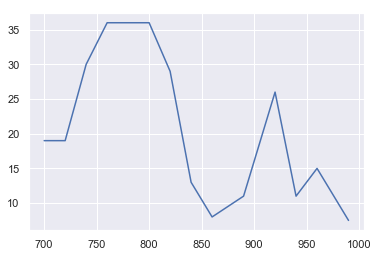

In [11]:
plt.plot(x/nm, fl2.sigma2(x)/GM)

## The setup

- The idea is to proceed to a raster scan, with the microscope focused in a small region, so that the regime is diffusion dominated. 
- The concentration of the dye is 10 nM. Assuming that the size of the spot is roughly 1 micron  we expect to see about 20 molecules per fov

### Laser beam

In [12]:
lb = PulsedLaser(lamda=800*nm, power=350*mW, f=76*MHZ, tau=400*femtosecond)  
lb


        Pulsed Laser:
        wavelength                =8.0e+02 nm
        photon energy             =1.6e+00 eV
        power                     =3.5e+02 mW
        repetition rate           =7.6e+01 kHz
        pulse width               =4.0e+02 fs
        energy per pulse          =2.7e+04 fJ
        energy per second         =3.5e+02 mJ
        photons per second        =3.5e+02 ph/second
        

### Microscope

In [13]:
mc = Microscope(name='Espinardo', numerical_aperture=0.5, magnification=20)
print(mc)


        name                 = Espinardo
        NA                   =   0.5
        M                    =  20.0
        eff dichroic         =  0.85
        eff filter           =  0.80
        Optical transmission =  0.96
        Filter  transmission =  0.68
        Total transmission   =  0.65
        


### Scanning 
- area $90 \times 90 \mu m$.
- pixels 256 x 256 (puede llegar a 512 x 512)

In [14]:

pixel_size_mu_a = 90 * mum /(256)
pixel_size_mu_b = 90 * mum /(512)

In [15]:
print(f'pixel size conf A= {pixel_size_mu_a/nm:5.1e} nm')
print(f'pixel size conf B= {pixel_size_mu_b/nm:5.1e} nm')

pixel size conf A= 3.5e+02 nm
pixel size conf B= 1.8e+02 nm


### Difraction limit

In [16]:
dl = diffraction_limit(lb, mc)
print(f'diffraction limit = {dl/nm}  nm')

diffraction limit = 976.0  nm


### Assume a FOV of size diffraction limit

z is set to 0.04 mm, see
https://www.osapublishing.org/DirectPDFAccess/6D7E7982-90AC-2FC4-1BC45ECB85CF58B0_33721/josab-13-3-481.pdf?da=1&id=33721&seq=0&mobile=no

In [17]:
fov= CircularFoV(d = dl, z= 5 * lb.lamda * mm)
fov


        FOV; d = 9.8e-04 mm; r = 4.9e-04 mm; z = 4.0e-03 mm;
        area = 7.5e-07 mm2 volume = 3.0e-09 mm3
        

### Density of photons in that area

In [18]:
I = photon_density(lb, fov)
print(f'photon density = {I/(us*ucm2):5.1e} photons/(second cm2)')

photon density = 1.9e+26 photons/(second cm2)


In [19]:
print(f'photon density per pulse= {I/lb.tau/(us*ucm2):5.1e} photons/(second cm2)')

photon density per pulse= 4.7e+29 photons/(second cm2)


### Dye of 10 nm concentration 

In [20]:
ds = DyeSample(name='f2p',concentration = 10 * nanomole/l, volume= fov.volume())
ds


        Dye name =f2p;
        concentration = 1.0e-08 mole/l (6.0e+12 molecules/cm3);
        V = 3.0e-15 l,
        nof molecules = 1.8e+01
        

In [21]:
print(f' laser power in photons/second ={lb.n_photons()/us:5.2e}')

 laser power in photons/second =1.41e+18


In [22]:
gb = GaussianBeam(lb, dl)

### Equation 15

https://www.osapublishing.org/DirectPDFAccess/6D7E7982-90AC-2FC4-1BC45ECB85CF58B0_33721/josab-13-3-481.pdf?da=1&id=33721&seq=0&mobile=no

Fluorescence produced by 2 photon absorption (efficiency of detection system = 1 in this formula, computed separatedly)

$$ F(t) = \frac{1}{2} Q \sigma_2 C \frac{g_p}{f \tau} \frac{8 n P(t)^2}{\pi \lambda}$$

where:
- Q is the quantum efficiency (0.9 for fluorescein)
- $\sigma_2$ is the two photon absorption cross section (in cm$^4$ s)
- C is the concentration (molecules/cm$^3$)
- $g_p = 0.66$ (see paper)
- f is the frequency (e.g, 80 MHZ)
- $\tau$ is the FWHM of the pulse width (e.g, 400 fs)
- n is the refraction index
- P(t) is the number of photons per unit time in the sample
- $\lambda$ is the wavelength of the light

- units are photons/second

In [23]:
def fluorescence_2p_t(ds: DyeSample, m: Molecule2P, lb: GLaser, n: float = 1)->float:
    """
    Returns the number of photons emitted by fluorescence through 2 photon absorption
    in the focal volume of a strongly focused illumination (e.g, diffraction limited)
    """
    gp    = 0.66
    Q     = m.Q   
    delta =  m.sigma2(lb.lamda)/ (cm2*cm2*s)
    C     = ds.rho_molecules() /ucm3
    ftau  = lb.f * lb.tau
    lamda =  lb.lamda / cm
    P0    =  lb.n_photons()/us
    
    print(f' Q  ={Q:5.1e} ')
    print(f' delta = {delta:5.1e} cm4 second / (photon molecule)')
    print(f' Concentration = {C:5.1e} molecules/cm3')
    print(f' P0 = {P0:5.1e} photons/second')
    print(f' ftau = {ftau:5.1e}')
    print(f' landa = {lamda:5.1e} cm')

    t1 = 0.5 * Q * delta
    t2 = C * gp/ftau
    t3 = 8 * n/(np.pi * lamda)
    t4 = P0**2
    
    print(f' t1 ={t1:5.1e}')
    print(f' t2 ={t2:5.1e}')
    print(f' t3 ={t3:5.1e}')
    print(f' t4 ={t4:5.1e}')
    
    fa = t1 * t2 * t3 * t4
    fb = 0.5 * m.Q* m.sigma2(lb.lamda) * ds.rho_molecules() * (gp /(lb.f * lb.tau)) *(8 * n * lb.n_photons()**2) / (np.pi * lb.lamda)
    
    print(f'fa ={fa:5.1e}  photons / second ')
    print(f'fb ={fb/us:5.1e}  photons / second ')

    return   fa


In [24]:
Ft = fluorescence_2p_t(ds, fl2, lb)

 Q  =9.0e-01 
 delta = 3.6e-49 cm4 second / (photon molecule)
 Concentration = 6.0e+12 molecules/cm3
 P0 = 1.4e+18 photons/second
 ftau = 3.0e-05
 landa = 8.0e-05 cm
 t1 =1.6e-49
 t2 =1.3e+17
 t3 =3.2e+04
 t4 =2.0e+36
fa =1.3e+09  photons / second 
fb =1.3e+09  photons / second 


In [25]:
F = fluorescence_2p(ds, fl2, lb)

In [26]:
print(f' F = {F/us:5.1e} photons/second')

 F = 1.3e+09 photons/second


### According to calculation a large number of fluorescence photons are produced even for small concentrations

### Assuming a gaussian beam

In [27]:
print(f' zr = {gb.zr/mum:5.1e} mum')

 zr = 3.7e+00 mum


In [31]:
print(f' I0 = {gb.I0/(W/cm2):5.1e} W/cm2)')

 I0 = 2.3e+07 W/cm2)


In [32]:
wz = gb.w(0)
print(f' w0 = {gb.w0/mum:5.1e} mu ; wz = {wz/mum:5.1e} mu ')

 w0 = 9.8e-01 mu ; wz = 9.8e-01 mu 


In [33]:
g = gb.g(0, 0)
print(f' g = {g:5.1e}')

 g = 1.0e+00


## Number of absorbed photons, per fluorophere per pulse

http://www.aomf.ca/pdfs/Denk1990.pdf

- equation 9 (in references)

$$ na = \frac{P^2 Q \sigma_2}{\tau f} (\frac{A^2}{2 \hbar c \lambda})^2$$

where:
- Q is the quantum efficiency (0.9 for fluorescein)
- $\sigma_2$ is the two photon absorption cross section (in cm$^4$ s)
- A is the numerical aperture
- f is the frequency (e.g, 80 MHZ)
- $\tau$ is the FWHM of the pulse width (e.g, 400 fs)
- P is the laser power
- $\lambda$ is the wavelength of the light

- units are photons/fluorophene


In [27]:
def absorbed_photons_per_fluorophore_per_pulse_2p_t( p0mW : float, deltaGM : float, taufS: float, fMHz : float, A : float, lamdanM: float) ->float:
    """
        p0    -> mW
        tau   -> fs
        f     -> MHz
        lamda -> nm
        delta -> cm^4 s
        na = (p0^2 * delta)/(tau * f^2) * (A^2/(2 hbarc * lambda))^2
        where hbarc = hbar * c = 3.16 x 10^{-26} J m = 3.16 x 10^{-24} J cm
        
        thus dimensions:
        p0^2 --> (E/t)^2 -> J^2 * s^-2
        p0^2 * delta -> J^2 cm^4 s^-1
        tau * f^2 = tau * f *f -> [s][s^-1][s^-1]
        (p0^2 * delta)/(tau * f^2) -> J^2 cm^4
        A^2/(2 hbarc * lambda) -> J^-1 cm-2
        (p0^2 * delta)/(tau * f^2) * (A^2/(2 hbarc * lambda))^2 J^2 cm^4 J^-2 cm^-4
    """
    hbarc = 3.16    * 1e-24      # J cm 
    p0    = p0mW    * 1e-3       # mW to W (J/S)
    delta = deltaGM * 1e-50      # GM to cm4 s
    tau   = taufS   * 1e-15      # fs to s
    f     = fMHz    * 1e+6       # hZ to MHz
    l     = lamdanM * 1e-7       # nm to cm
    
    print(f'p0  ={p0}')
    print(f'(delta  ={delta}')
    print(f'(p0**2 * delta) ={(p0**2 * delta)}')
    print(f'(tau * f**2)    ={(tau * f**2)}')
    print(f'(p0**2 * delta) / (tau * f**2)    ={(p0**2 * delta)/ (tau * f**2)}')
    print(f'(2 * hbarc * l)                   ={2 * hbarc * l}')
    print(f'((A**2 / (2 * hbarc * l))**2      ={(A**2 / (2 * hbarc * l))**2}')
    
    return ((p0**2 * 0.9 * delta) / (tau * f**2)) * (A**2 / (2 * hbarc * l))**2 

In [28]:
na = absorbed_photons_per_fluorophore_per_pulse_2p_t(lb.power/mW, fl2.sigma2(lb.lamda)/GM, lb.tau/femtosecond, lb.f/MHZ, mc.numerical_aperture, lb.lamda/nm)

p0  =0.35
(delta  =3.6e-49
(p0**2 * delta) =4.409999999999999e-50
(tau * f**2)    =2310.4
(p0**2 * delta) / (tau * f**2)    =1.9087603878116338e-53
(2 * hbarc * l)                   =5.0559999999999995e-28
((A**2 / (2 * hbarc * l))**2      =2.444926944800513e+53


In [29]:
na

4.2001017329956865

In [30]:
na = absorbed_photons_per_fluorophore_per_pulse_2p(fl2, lb, mc)

 p0         = 0.35 J/s
 Q * delta  = 3.2400000000000003e-49 cm4 s/ (molecule photon)
 tau * f**2 = 2310.4000000000005 s^-1
 hbarc      = 3.16e-24 J cm
 lamda      = 8.000000000000002e-05 cm
 A          = 0.5 
 (p0**2 * m.Q * delta) / (tau * f**2) = 1.7178843490304706e-53 J^2 cm^4
((A**2 / (2 * hbarc * lamda))**2       =2.444926944800512e+53 J^-2 cm^-4


In [31]:
print(f' number of absorbed photons per fluorophore per pulse = {na:5.1e}')

 number of absorbed photons per fluorophore per pulse = 4.2e+00


#### This implies that the number of photons per pulse saturates the fluorophore. Thus, each pulse will absorb two photons. In other words, one could reach the limit of 2 photons per fluorophene with (2/2.6 x 10^2) less power

In [32]:
power_to_saturate_fluorescence = (2/na) *lb.power
print(f'power_to_saturate_fluorescence={power_to_saturate_fluorescence/mW:5.1e} mW')

power_to_saturate_fluorescence=1.7e+02 mW


### The number of photons per fluorophere per second should then simply be equal to the number of pulses, sice we saturate

In [33]:
n_pulses_per_second = lb.f/hertz
print(f' number of absorbed photons per fluorophore per second = {n_pulses_per_second:5.1e}')

 number of absorbed photons per fluorophore per second = 7.6e+07


### The number of absorbed photons in the sample depends on the number of molecules in the sample. We can use the formulas above to estimate the number of molecules in a diffraction-limited system.

In [36]:
fs = F/us
n = fs / n_pulses_per_second
n

17.623261774172374

In [37]:
print(f' number of molecules in dye = {n:5.1e}')

 number of molecules in dye = 1.8e+01


In [38]:
print(f' F = {F/us:5.1e} photons/second')
print(f' number of absorbed photons per fluorophore per second = {n_pulses_per_second:5.1e}')
print(f' number of molecules in dye for a concentracion of {ds.rho_molecules()/ucm3:5.1e} = {n:5.1e}')

 F = 1.3e+09 photons/second
 number of absorbed photons per fluorophore per second = 7.6e+07
 number of molecules in dye for a concentracion of 6.0e+12 = 1.8e+01


In [40]:
l = 0.5**2 * np.pi /1.57
l

0.5002536072595212

In [34]:
2**10

1024